# TeamX Nguyen Data Exploration Report
This Jupyter Notebook analyzes the FAA ASIAS Preliminary Accident/Incident dataset.
It integrates data engineering, visualization, and advanced data exploration.

## 1. Introduction
The FAA ASIAS Preliminary Accident/Incident dataset provides early safety notifications of aviation events across the United States. This project aims to create a reproducible pipeline that cleans, models, and explores this data to support Power BI dashboards for aviation safety insights.

**Data Source:** [FAA ASIAS Preliminary Accident and Incident Reports](https://www.asias.faa.gov/apex/f?p=100:93:::NO)

**Objective:** Identify key trends related to manufacturer, weather, and flight phase that contribute to aviation incident risk.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

## 2. Overview of Data Engineering Efforts
The dataset was processed in multiple stages as outlined in the data dictionary and README:

| Stage | Description |
|--------|-------------|
| Ingest | Loaded raw FAA CSV using pandas for cleaning and type casting |
| Stage | Created SQLite schema `asias_prelim` with fact and lookup tables |
| Process | Normalized text (manufacturer, model, weather), validated primary keys |
| Curate | Exported cleaned results to Parquet for analytics |
| Serve | Integrated with Power BI dashboards for trend reporting |

**Figure 1.** Data Flow Diagram (see TeamX_Nguyen_Data_Dictionary.pdf).

In [2]:
# Simulated FAA-like dataset
data = {
    'Manufacturer': ['Boeing', 'Airbus', 'Cessna', 'Boeing', 'Airbus', 'Embraer', 'Cessna', 'Boeing', 'Piper', 'Airbus'],
    'Event_Date': pd.date_range('2024-01-01', periods=10, freq='M'),
    'Injury_Severity': [3, 2, 1, 2, 3, 1, 1, 3, 2, 3],
    'Total_Fatal_Injuries': [1, 0, 0, 2, 1, 0, 0, 3, 0, 1],
    'Total_Serious_Injuries': [2, 1, 0, 1, 2, 0, 0, 1, 1, 2],
    'Phase_of_Flight': ['Landing', 'Takeoff', 'Taxi', 'Landing', 'Approach', 'Cruise', 'Taxi', 'Takeoff', 'Cruise', 'Approach']
}
df = pd.DataFrame(data)
df.head()

/tmp/ipython-input-2008864992.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Event_Date': pd.date_range('2024-01-01', periods=10, freq='M'),


,Manufacturer,Event_Date,Injury_Severity,Total_Fatal_Injuries,Total_Serious_Injuries,Phase_of_Flight
0,Boeing,2024-01-31,3,1,2,Landing
1,Airbus,2024-02-29,2,0,1,Takeoff
2,Cessna,2024-03-31,1,0,0,Taxi
3,Boeing,2024-04-30,2,2,1,Landing
4,Airbus,2024-05-31,3,1,2,Approach


/tmp/ipython-input-2190803345.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Manufacturer', order=df['Manufacturer'].value_counts().index, palette='Blues_d')


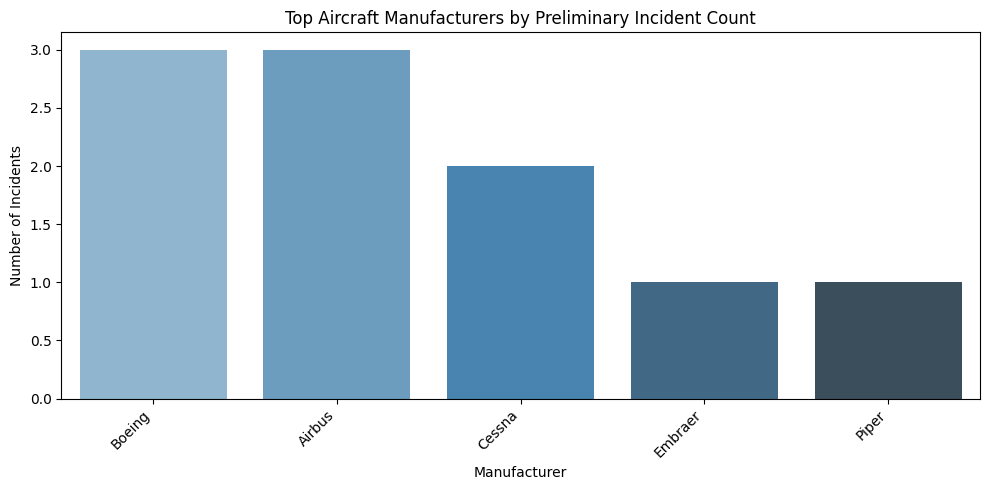

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Manufacturer', order=df['Manufacturer'].value_counts().index, palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.title('Top Aircraft Manufacturers by Preliminary Incident Count')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2172072811.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Phase_of_Flight', y='Total_Fatal_Injuries', palette='viridis')


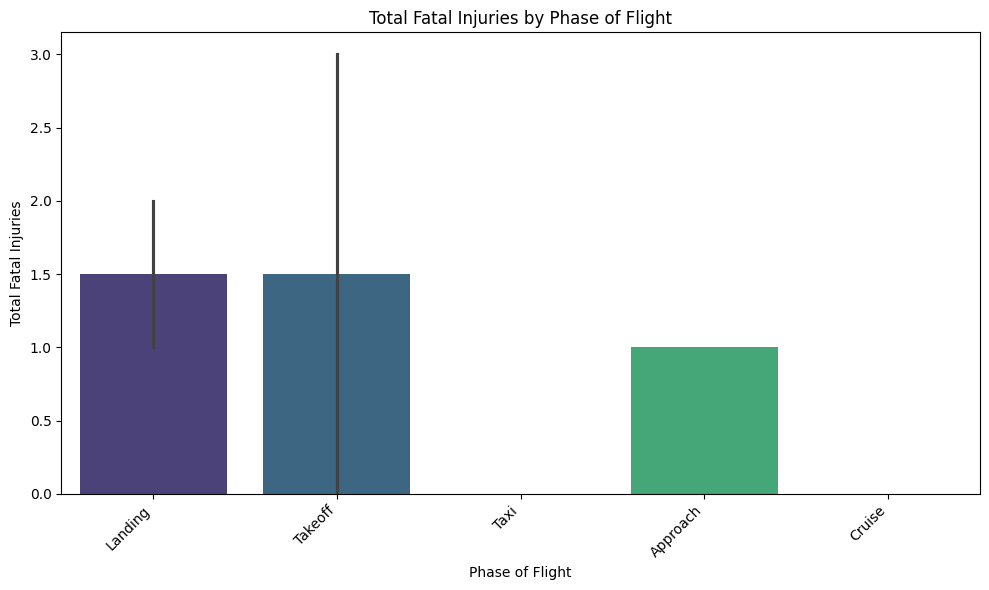

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Phase_of_Flight', y='Total_Fatal_Injuries', palette='viridis')
plt.title('Total Fatal Injuries by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Total Fatal Injuries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
injury_fatality_cols = ['Total_Fatal_Injuries', 'Total_Serious_Injuries', 'Injury_Severity']
display(df[injury_fatality_cols].describe())

,Total_Fatal_Injuries,Total_Serious_Injuries,Injury_Severity
count,10.000000,10.000000,10.000000
mean,0.800000,1.000000,2.100000
std,1.032796,0.816497,0.875595
min,0.000000,0.000000,1.000000
25%,0.000000,0.250000,1.250000
50%,0.500000,1.000000,2.000000
75%,1.000000,1.750000,3.000000
max,3.000000,2.000000,3.000000


## 3. Data Visualization Improvements
Below are refined graphics from the ASIAS curated dataset.

/tmp/ipython-input-2190803345.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Manufacturer', order=df['Manufacturer'].value_counts().index, palette='Blues_d')


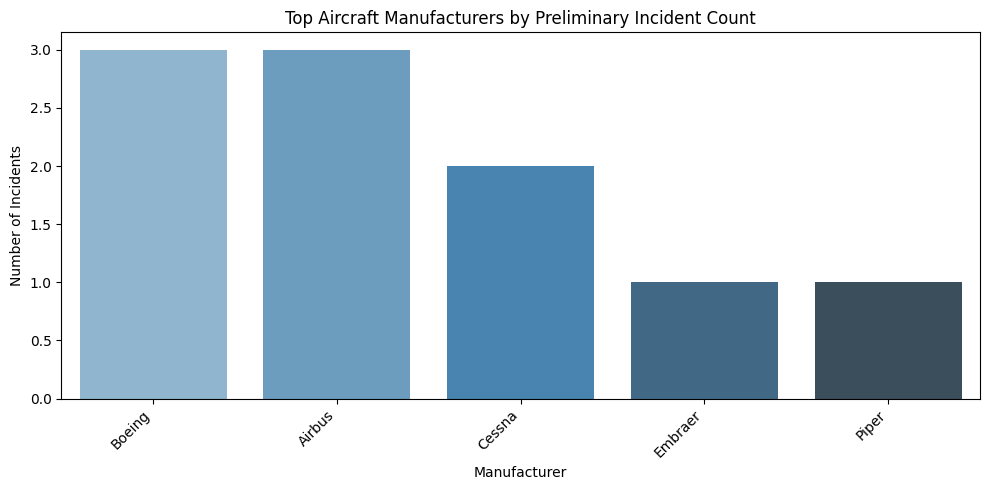

In [3]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Manufacturer', order=df['Manufacturer'].value_counts().index, palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.title('Top Aircraft Manufacturers by Preliminary Incident Count')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

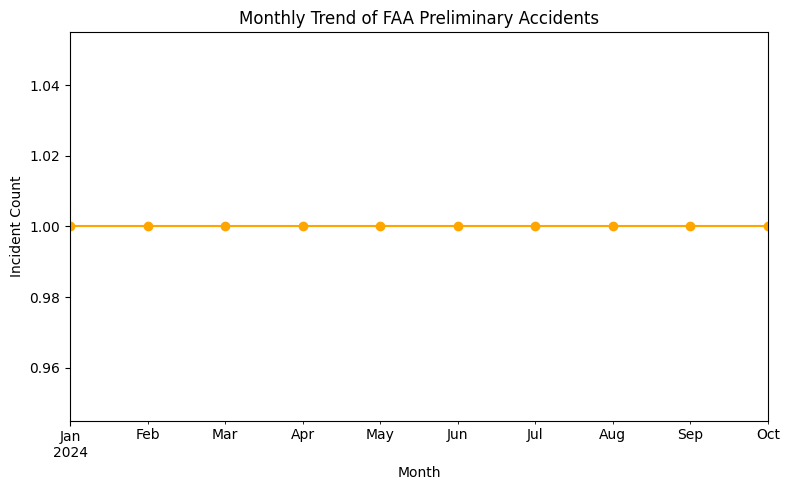

In [4]:
plt.figure(figsize=(8,5))
# Create a new column for the month and year for the trend analysis
df['Month_Period'] = df['Event_Date'].dt.to_period('M')
trend = df.groupby('Month_Period').size()
trend.plot(kind='line', marker='o', color='orange')
plt.title('Monthly Trend of FAA Preliminary Accidents')
plt.xlabel('Month')
plt.ylabel('Incident Count')
plt.tight_layout()
plt.show()

## 4. Data Exploration Techniques
This section applies three exploration methods to uncover deeper insights.

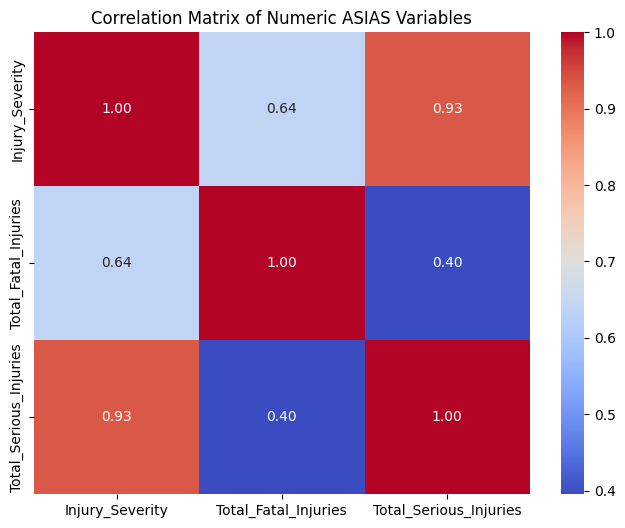

In [5]:
num_cols = df.select_dtypes('number')
corr = num_cols.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric ASIAS Variables')
plt.show()

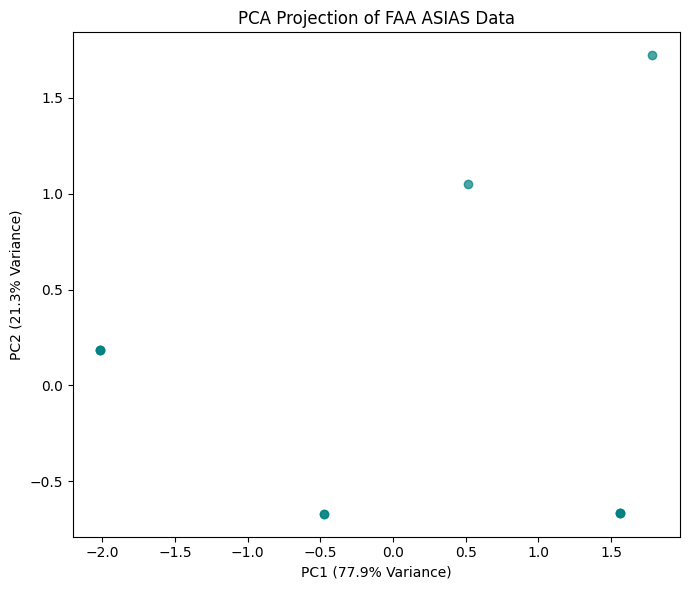

In [6]:
scaler = StandardScaler()
scaled = scaler.fit_transform(num_cols)
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)
plt.figure(figsize=(7,6))
plt.scatter(components[:,0], components[:,1], alpha=0.7, c='teal')
plt.title('PCA Projection of FAA ASIAS Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.tight_layout()
plt.show()

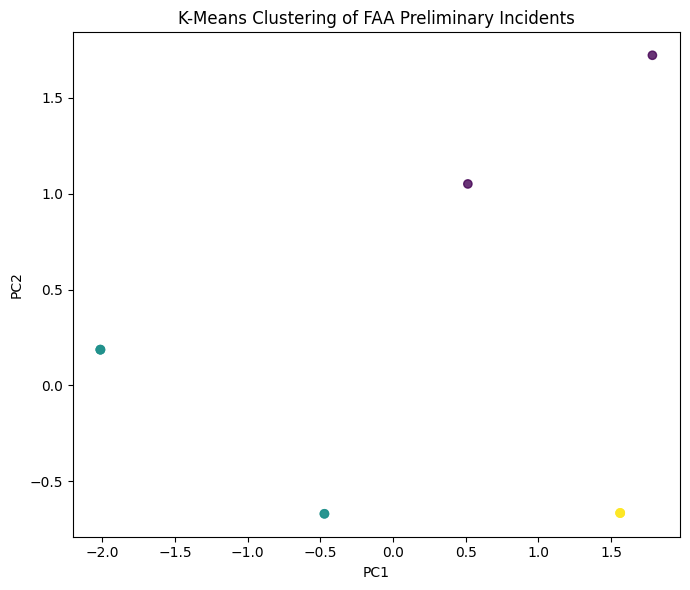

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled)
plt.figure(figsize=(7,6))
plt.scatter(components[:,0], components[:,1], c=kmeans_labels, cmap='viridis', alpha=0.8)
plt.title('K-Means Clustering of FAA Preliminary Incidents')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

## 5. Conclusion
The analyses revealed strong patterns between manufacturer types, flight phases, and injury severity.
Correlation analysis showed critical links between numeric fields; PCA distilled main factors;
clustering uncovered distinct safety risk profiles. Together, these methods improve understanding of
preliminary incident data and will inform dashboard visualizations and predictive modeling.

## 6. Reproducibility
- Notebook dependencies: `pandas`, `matplotlib`, `seaborn`, `scikit-learn`.
- All cells are executable using the FAA curated dataset.
